# Decision Tree Classifier - Cost-Complexity Pruning

### Introduction to CCP

Typically, trees are pruned as they are grown to prevent overfitting with the hyperparameters _max_depth_, _min_samples_leaf_ and _min_samples_split_. In the previous section, _max_depth_ was used for pruning. Another popular method is to let the tree grow without any restrictions. The result of this is called the _full tree_ which often overfits the training data. In cost-complexity pruning, the full tree is trimmed down into a suitable subtree that has less nodes by removing branches that offer minimal improvement in predictive performance. The trimmed is tree is more generalisable with a higher accuracy on the testing dataset. In sci-kit learn, we grow a full tree by specifying no arguments to the _DecisionTreeClassifier_ class,

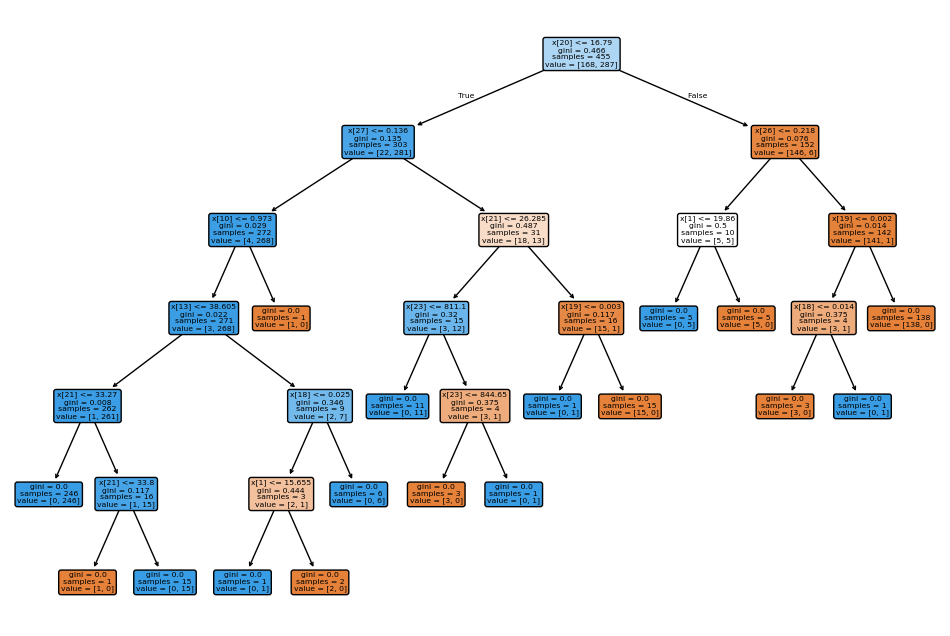

Number of nodes: 33


0.8947368421052632

In [29]:
# Importing
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier as SKDecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Creating dataset,
iris_dataset = load_breast_cancer()
X = iris_dataset["data"]
y = iris_dataset["target"]

# Creating model and fitting,
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

# Creating model and fitting,
clf = SKDecisionTreeClassifier(random_state=0)
clf.fit(X_train, y_train)

# Printing the tree,
plt.figure(figsize=(12, 8))
plot_tree(
    decision_tree=clf,
    filled=True,
    rounded=True
)
plt.show()

# Scoring,
print(f"Number of nodes: {clf.tree_.node_count}")
clf.score(X_test, y_test)

Following the relevent documentation https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html and https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.cost_complexity_pruning_path, we perform cost-complexity by determining values for the CCP hyperamater $\alpha$ that determines how much we want to prune the full tree.


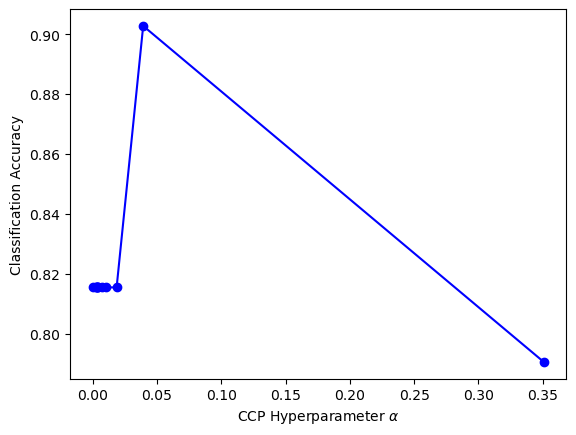

CCP_alpha: 0.03917835910621522, Score: 0.9027667984189722


In [30]:
# It is best practice to use cross-validation,
from sklearn.model_selection import cross_val_score

# Creating list for trimmed trees,
clfs = []
scores = []

# Computing alphas,
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Creating trees,
for ccp_alpha in ccp_alphas:
    clf = SKDecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0)
    clf.fit(X_train, y_train)
    clfs.append(clf)

    # Scoring each tree,
    score = np.mean(cross_val_score(clf, X_test, y_test, cv=5))
    scores.append(score)

# Plotting each model against its alpha value,
plt.plot(ccp_alphas, scores, color="blue", marker="o")
plt.xlabel(r"CCP Hyperparameter $\alpha$")
plt.ylabel(r"Classification Accuracy")
plt.show()

# Printing optimal alpha value,
optimal_alpha, highest_score = ccp_alphas[np.argmax(scores)], np.max(scores)
print(f"CCP_alpha: {optimal_alpha}, Score: {highest_score}")

Inspecting our best pruned trees,

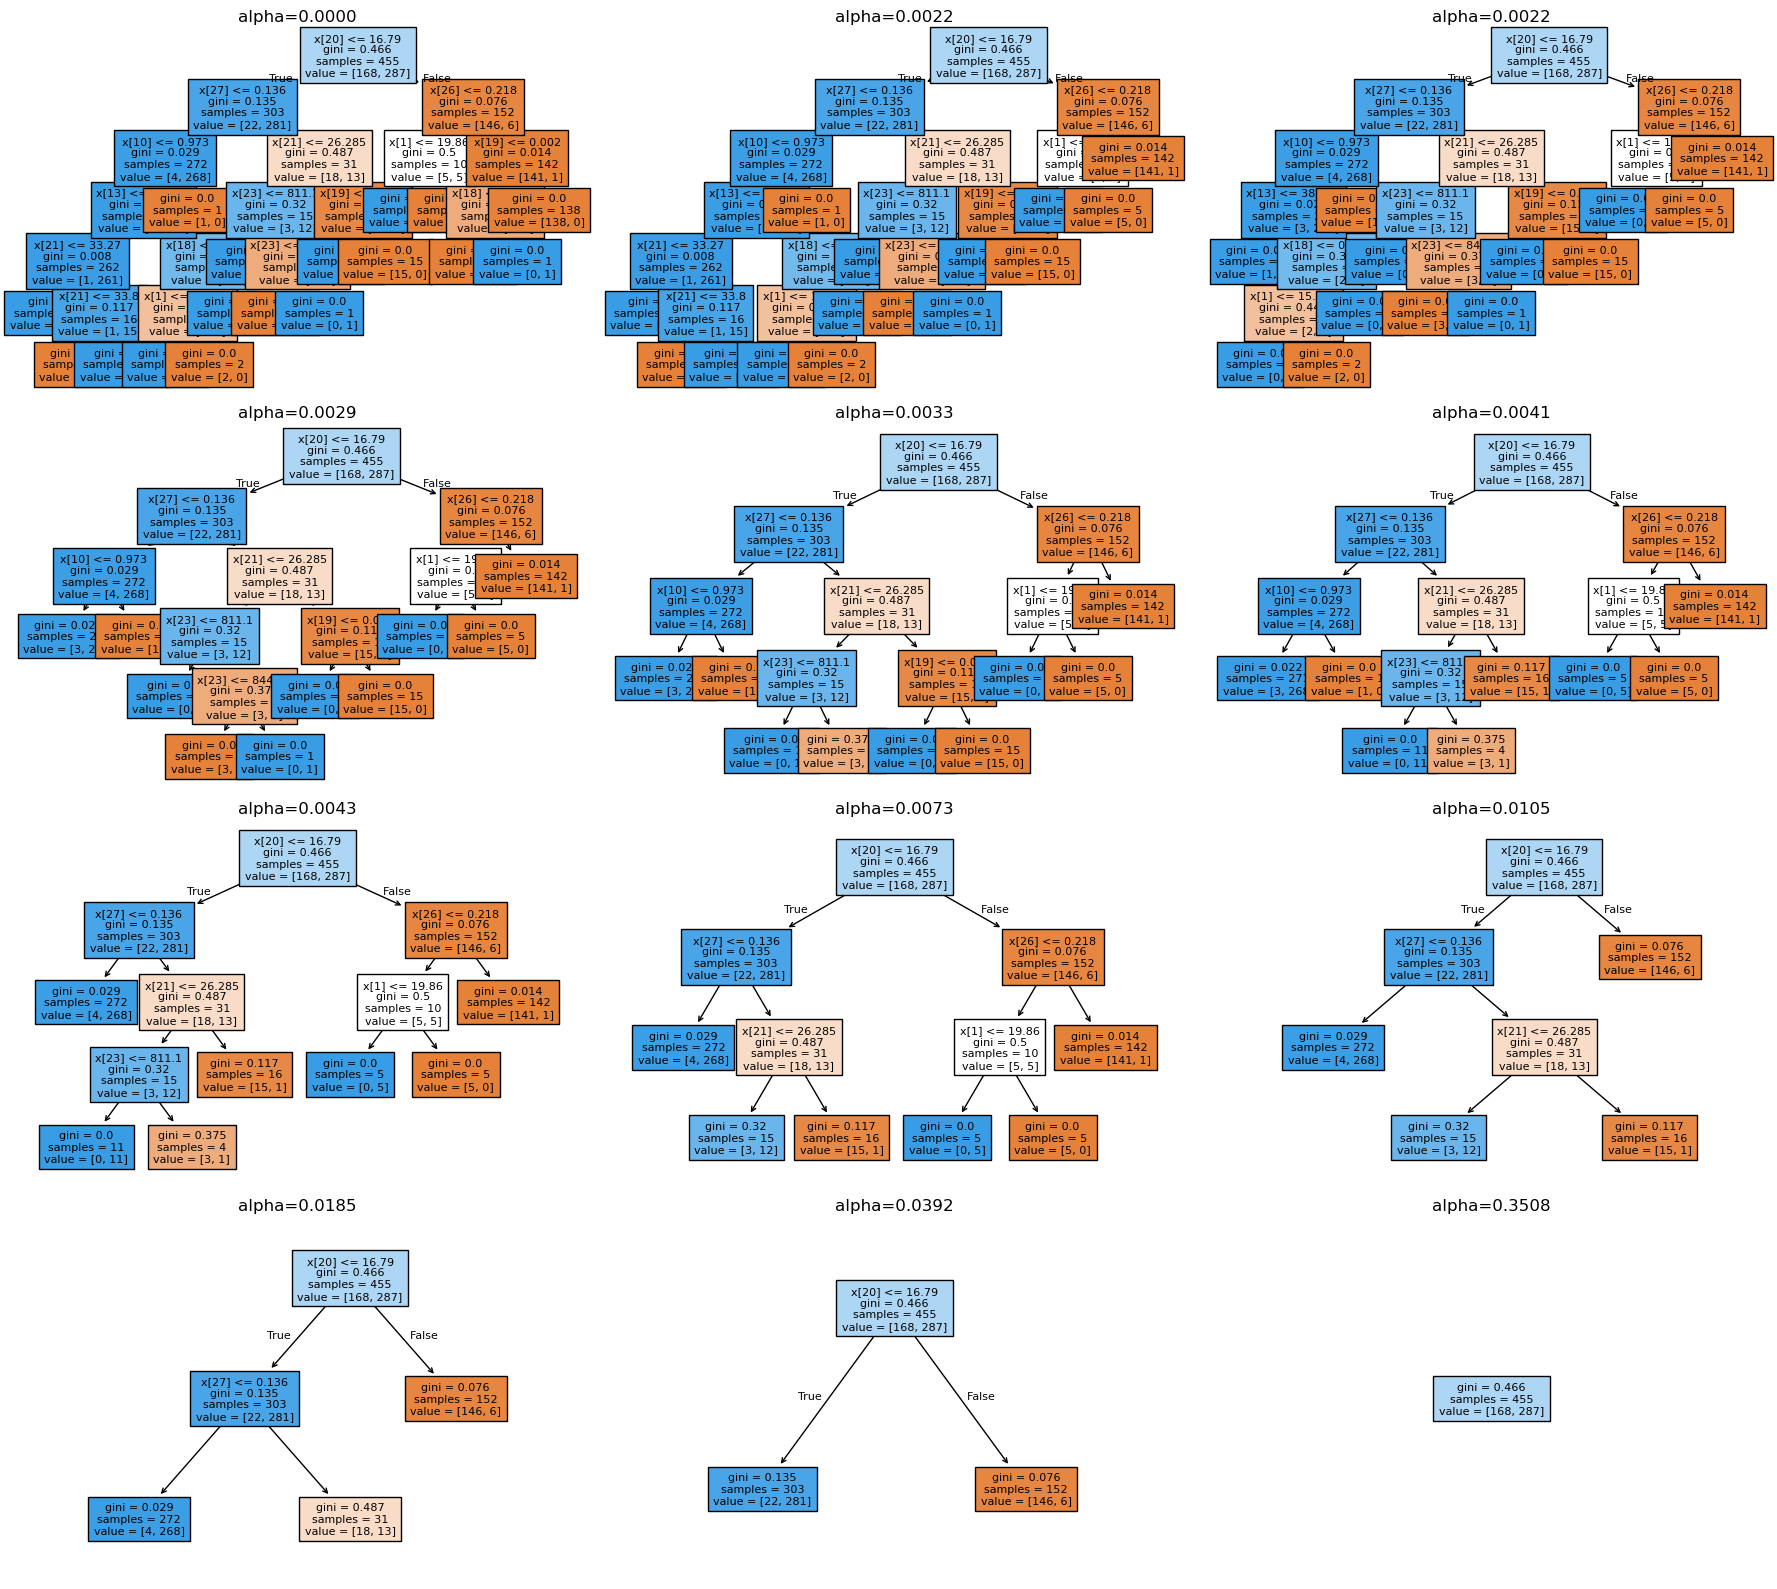

In [8]:
# Number of trees
n_trees = len(clfs)

# Set up subplots: We'll arrange them in a grid
n_cols = 3  # Number of columns in the plot grid
n_rows = int(np.ceil(n_trees / n_cols))

plt.figure(figsize=(n_cols*6, n_rows*4))

for i, clf in enumerate(clfs):
    plt.subplot(n_rows, n_cols, i + 1)
    plot_tree(clf, filled=True, fontsize=8)
    plt.title(f"alpha={ccp_alphas[i]:.4f}")

plt.tight_layout()
plt.show()


### CPP From First Principles

Let us now implement cost-complexity pruning from the ground up. First let us establish some notation, we denote $\mathcal{T}_{0}$ to be our fully grown decision tree where we have not set a `maximum_depth` and kept `min_samples_leaf` and `min_samples_split` to their minimum values. $\mathcal{T}_{m}$ is then a sub-tree of the full tree whose root node is an internal node marked as $m$. We introduce a new quantity for each node called risk $R_m$,

$$R_m = p_m G_m$$

In which, $R_m$ is the risk of the $m$-th node, $p_m = N_m/N$ is the proportion of data point within the node compared to the total number and $G_m$ is the Gini index of the node. More abstractly, $G_m$ can be replaced with any other metric that quantifies the impurity of a node. It follows that the total risk of a tree is then $R(\mathcal{T}_{m})$,

$$R(\mathcal{T}_{m}) = \sum_{j \in L_m} R_j$$

Meaning that the total risk of a tree is simply the sum of the risks of its leaf nodes. Our aim in CPP is find a sub-tree of $\mathcal{T}_{0}$ that mimises risk and also has fewer leaf nodes. Hence, we have an objective function $J$ of the form,

$$J(\mathcal{T}_{m}) = R(\mathcal{T}_{m}) + \alpha \mathcal{N}_{m}$$

A new hypermater $\alpha$ is introduced. We refer to it as the cost and it controls the extend to which we want to prune the full tree. Note that $\mathcal{N}_{m}$ denotes that number of leaf nodes belonging to the sub-tree $\mathcal{T}_{m}$. The idea is to find the optimal tree $\mathcal{T}_{\alpha}$ for some $\alpha$ that minimises the objective function $J(\mathcal{T}_{m})$ such that, 

$$
\mathcal{T}_\alpha  =\arg\min_{\mathcal{T}_m \subseteq \mathcal{T}_0} \left\{ R(\mathcal{T}_m) + \alpha\,\mathcal{N}_m \right\}
$$

Luckily, one does not have to exhaustively evaluate the objective function for every possible sub-tree of the full tree in a brute-force way. Instead, a bottom-up approach can be considered since the sub-trees are nested. In practice that means we consider a recursive algorithm when pruning the tree. The pruning rule is often written as,

$$(\mathcal{N}_m - 1) \alpha > R_m - R(\mathcal{T}_m)$$

The LHS is called the penality of the sub-tree $\mathcal{T}_m$, it is the the number of leaves removed from the full tree $\mathcal{T}_0$ when we prune off $R(\mathcal{T}_m)$ from it $(\mathcal{N}_m - 1) $ multiplied by the cost $\alpha$. While the RHS is the reward of having the sub-tree. We perform pruning when the penality of the sub-tree is greater than the reward of having it. It is more convenient to rewrite this condition as,

$$\alpha > \frac{R_m - R(\mathcal{T}_m)}{(\mathcal{N}_m - 1)} = C_{m}$$

where we have introduced $C_{m}$ as the effective cost of the sub-tree. Our condition for pruning is then: If the effective cost $C_{m}$ of a sub-tree is greater than the cost hyperparameter $\alpha$ we should prune of the sub-tree $\mathcal{T}_m$ from our existing tree. Therefore, by recursively applying this condition for pruning we obtain,

$$\mathcal{T}_0 \supset \mathcal{T}_1 \supset \cdots \supset \mathcal{T}_K,$$

Our final tree after $K$ number of pruning actions is our optimal sub-tree $\mathcal{T}_K = \mathcal{T}_{\alpha}$ of $\mathcal{T}_0$ that minimises our objective $J$ for some cost hyperparameter $\alpha$. Now that we have established the relevant mathematically details, let us implement it in Python,

In [3]:
# Importing,
import copy
import numpy as np

class DecisionTreeClassifier():
    """This class implements a DecisionTreeClassifier using the CART algorithm with the functionality of NumPy."""

    def __init__(self, max_depth=None, min_samples_leaf=1, min_samples_split=2):
        """Constructor method for the DecisionTreeClassifier class. We simply create the class variables."""

        # Class variables for the data and nodes,
        self.X, self.y, self.tree_root = None, None, None

        # Stopping criteria,
        if max_depth is None:
            self.max_depth = np.inf
        else:
            self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.min_samples_split = min_samples_split

        return None

    def fit(self, X, y):
        """Use this method to fit the tree to the training dataset."""

        # Assignment to class attributes,
        self.X, self.y = X, y

        # Growing the tree,
        self.tree_root = self._grow_tree(X=X, y=y, node_label="O", current_depth=0) # <-- The label "O" is for the root node.

        return None

    def predict(self, X):
        """Wrapper method around _traverse_tree() for predictions."""

        # Traversing the tree,
        preds = np.asarray([self._traverse_tree(x, self.tree_root) for x in X]) # <-- Starting at the root node.

        return preds

    def score(self, X, y):
        """Computes the accuracy of the model of the given data."""

        # Storing predictions as an array,
        y_preds = self.predict(X)

        # Computing accuracy,
        accuracy = np.sum(y == y_preds)/len(y)

        return accuracy

    def print_tree(self, structural=True):
        """Prints the structure of the tree using _traverse_tree_print which traverses the tree."""
        n_nodes = self._traverse_tree_print(node=self.tree_root, structural=structural)
        print(f"Number of nodes: {n_nodes}")
        return None

    def prune(self, alpha, inplace=True):
        """Calling this function allows for cost-complexity pruning."""

        if inplace:
            self._compute_cpp_info(node=self.tree_root)
            self._prune_tree(node=self.tree_root, alpha=alpha)
            return None
        else:
            clone_tree = copy.deepcopy(self) # <-- Copy of the tree is created.
            self._compute_cpp_info(node=clone_tree.tree_root)
            self._prune_tree(node=clone_tree.tree_root, alpha=alpha)
            return clone_tree

    def _grow_tree(self, X, y, node_label, current_depth):
        """This function is recursively called and is responsible for the creation of the tree. The function is called every time we create a new node in the tree."""

        # Creating node object,
        current_node = Node(X, y, node_label)

        """STOPPING CRITERIA: maximum depth reached."""
        if current_depth == self.max_depth:

            # Marking as leaf node,
            current_node.is_leaf = True

            # Computing prediction for leaf node,
            current_node.prediction = self._compute_prediction(y_node=current_node.y)

            # Returning leaf node,
            return current_node
        
        """STOPPING CRITERIA: parent node has equal or fewer than min_samples_split number of data points."""
        if len(y) < self.min_samples_split:
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

        # Splitting node,
        decision, children_data, node_labels, valid_split = self._split(X, y, parent_node=current_node)

        if valid_split: # <-- The case when we have a valid split.

            # Assigning decision to current node,
            current_node.decision = decision
        
            # Unpacking children data,
            X_left, X_right, y_left, y_right = children_data
            left_node_label, right_node_label = node_labels

            # Creating subtrees,
            current_depth += 1
            current_node.child_left = self._grow_tree(X=X_left, y=y_left, node_label=left_node_label, current_depth=current_depth) # <-- We grow the branch from the left node first.
            current_node.child_right = self._grow_tree(X=X_right, y=y_right, node_label=right_node_label, current_depth=current_depth) # <-- We backtrack and then grow the branches from the right nodes.

            # Returning our current node,
            return current_node

        else: #<-- The case when we do NOT have a valid split,

            # Our current node must be a leaf node,
            current_node.is_leaf = True
            current_node.prediction = self._compute_prediction(y_node=current_node.y)
            return current_node

    def _split(self, X, y, parent_node):
        """Binary splits a parent node into two child nodes based on the decision that mimises the SSE (sum of squared errors) of the
        child nodes."""

        # Placeholder variables,
        max_delta_gini = 0 # <-- Initial value
        split_threshold_value = None
        found_split = False
        X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = None, None, None, None

        # Extract Gini index of parent node,
        parent_gini = parent_node.gini

        # Double loop, first for each feature, second for each threshold value,
        for feature_idx in range(X.shape[1]):

            # Extracting feature values,
            X_feature = X[:, feature_idx]

            # Thresholds taken as the midpoint between sorted values,
            X_feature_sorted = np.sort(X_feature)
            thresholds = np.unique((X_feature_sorted[:-1] + X_feature_sorted[1:]) / 2)

            for threshold_value in thresholds:

                # Splitting data,
                left_split_idxs, right_split_idxs = np.where(X_feature <= threshold_value)[0], np.where(X_feature > threshold_value)[0]
                X_left_split, X_right_split = X[left_split_idxs], X[right_split_idxs]
                y_left_split, y_right_split = y[left_split_idxs], y[right_split_idxs]

                # Reject splits which result in child nodes having less data points that the minimum number,
                if len(left_split_idxs) < self.min_samples_leaf or len(right_split_idxs) < self.min_samples_leaf:
                    continue

                # Compute Gini index of children nodes,
                children_gini = (len(y_left_split)/len(y))*self._compute_gini(y_node=y_left_split) + (len(y_right_split)/len(y))*self._compute_gini(y_node=y_right_split)

                # Computing the difference in Gini index,
                delta_gini = parent_gini - children_gini
            
                # Tracking minimum SSE,
                if delta_gini > max_delta_gini:
                    
                    # Reassigning minimum SSE,
                    max_delta_gini = delta_gini
                    found_split = True

                    # Updating nodes associated with the best split,
                    split_threshold_value, split_feature = threshold_value, feature_idx
                    X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split = X_left_split, X_right_split, y_left_split, y_right_split

        # Returning relevant data,
        if found_split: # <-- Case 1: We have found a valid split.

            # Packaging data to return,
            node_labels = ((parent_node.label + "L"), (parent_node.label + "R"))
            decision = (split_feature, split_threshold_value)
            children_data = (X_best_left_split, X_best_right_split, y_best_left_split, y_best_right_split)

            # Assigning node decision,
            parent_node.decision = decision

            return decision, children_data, node_labels, found_split
        else: #<-- Case 2: No valid split was found.
            return None, None, None, found_split

    def _traverse_tree(self, X_sample, node):
        """Helper function for traversing the tree recurvisely in order to make predictions."""

        if node.is_leaf: # <-- Reached terminal node.
            return node.prediction

        else: # <-- Node has a decision.
    
            # Extracting decision information,
            feature, feature_threshold = node.decision

            # Making decision,
            if X_sample[feature] <= feature_threshold:
                return self._traverse_tree(X_sample=X_sample, node=node.child_left)
            else:
                return self._traverse_tree(X_sample=X_sample, node=node.child_right)

    def _traverse_tree_print(self, node, structural, current_depth=0):
        """Traverses the tree via recursion."""

        # Counting the current node,
        node_count = 1

        if structural:

            # Printing maintains tree structure (pretty),
            indent = "  " * current_depth
            if node.is_leaf:
                print(f"{indent}Leaf → Predict: {node.prediction}")
            else:
                print(f"{indent}If X[:, {node.decision[0]}] <= {node.decision[1]}")
                node_count += self._traverse_tree_print(node.child_left, structural, current_depth + 1)
                print(f"{indent}Else:")
                node_count += self._traverse_tree_print(node.child_right, structural, current_depth + 1)

        else:
            if node.is_leaf:
                print(f"Node: {node.label}, Prediction: {node.prediction}, Gini Index: {node.gini}, Effective Cost: {node.effective_cost}")
            else:
                print(f"Node: {node.label}, Decision: {node.decision}, Effective Cost: {node.effective_cost}")
                node_count += self._traverse_tree_print(node.child_left, structural, current_depth + 1)
                node_count += self._traverse_tree_print(node.child_right, structural, current_depth + 1)

        # Returning node count,
        return node_count
    
    def _prune_tree(self, node, alpha):
        """Recursive function which prunes the tree."""

        # If the current node is a leaf, we cannot prune it,
        if node.is_leaf:
            return
        
        if node.child_left is not None:
            self._prune_tree(node.child_left, alpha)
        if node.child_right is not None:
            self._prune_tree(node.child_right, alpha)

        # If both children are leaf nodes, we now consider pruning the current node,
        if node.child_left is not None and node.child_right is not None:
            if node.child_left.is_leaf and node.child_right.is_leaf:

                # Pruning logic,
                if node.effective_cost < alpha:

                    # Cutting off branch,
                    node.child_left, node.child_right = None, None

                    # Converting internal node into leaf node,
                    node.is_leaf = True
                    node.prediction = self._compute_prediction(y_node=node.y)
                    node.decision = None

    def _compute_cpp_info(self, node):
        """This method traverses the tree to compute the effective cost of each node which is required for cost-complexity pruning (CPP)."""

        if node.is_leaf:
        
            # Computing risk,
            node_risk = self._compute_node_risk(node)
            return 1, node_risk

        # Resetting counts,
        n_leaves_accumulated, risk_accumlated = 0, 0

        # Post-order computation,
        subtree_nleaves_left, subtree_risk_left = self._compute_cpp_info(node.child_left)
        subtree_nleaves_right, subtree_risk_right = self._compute_cpp_info(node.child_right)

        # Computing number of leaves, risk and effective cost of subtree,
        n_leaves_accumulated += (subtree_nleaves_left + subtree_nleaves_right)
        risk_accumlated += (subtree_risk_left + subtree_risk_right)
        node_risk = self._compute_node_risk(node) # <-- Computing the risk of the current node (root of current sub-tree)
        effective_cost = (node_risk - risk_accumlated)/(n_leaves_accumulated - 1)

        # Assigning node attributes,
        node.effective_cost = effective_cost

        return n_leaves_accumulated, risk_accumlated

    def _compute_node_risk(self, node):
        return (len(node.y)/len(self.y))*node.gini

    @staticmethod
    def _compute_prediction(y_node):
        return np.argmax(np.bincount(y_node))

    @staticmethod
    def _compute_gini(y_node):
        p_class = np.unique(y_node, return_counts=True)[1]/len(y_node)
        return np.sum(p_class*(1-p_class))

class Node():
    """The class for node objects. Essentially used as a container."""

    def __init__(self, X, y, node_label):
        """Constructor method for the node. Class variables contain node information and encode its location in the tree
        required for predictions."""

        # Node information,
        self.X, self.y = X, y
        self.is_leaf = False
        self.decision = None
        self.prediction = None
        self.effective_cost = None

        # Encodes location in the tree,
        self.label, self.child_left, self.child_right = node_label, None, None

        # Computing Gini index,
        self.gini = DecisionTreeClassifier._compute_gini(y_node=y) if len(y) > 0 else 0

Let now use our implementation of cost-complexity pruning,

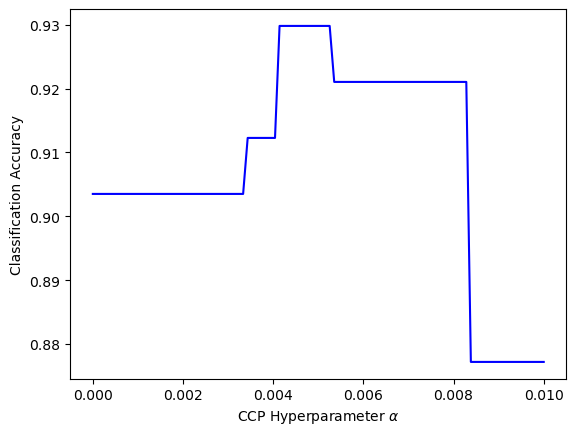

In [49]:
# Creating alphas,
ccp_alphas = np.linspace(start=0, stop=0.01, num=100)
clfs = []
scores = []

# Growing full tree,
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Progressively pruning the full tree until it is a stump,
for cpp_alpha in ccp_alphas:

    # Creating pruned tree,
    clf_pruned = clf.prune(alpha=cpp_alpha, inplace=False)
    clfs.append(clf_pruned)

    # Scoring the pruned tree,
    score = clf_pruned.score(X_test, y_test)
    scores.append(score)

# Plotting,
plt.plot(ccp_alphas, scores, color="blue")
plt.xlabel(r"CCP Hyperparameter $\alpha$")
plt.ylabel(r"Classification Accuracy")
plt.show()

Comparing this with sci-kit learn,

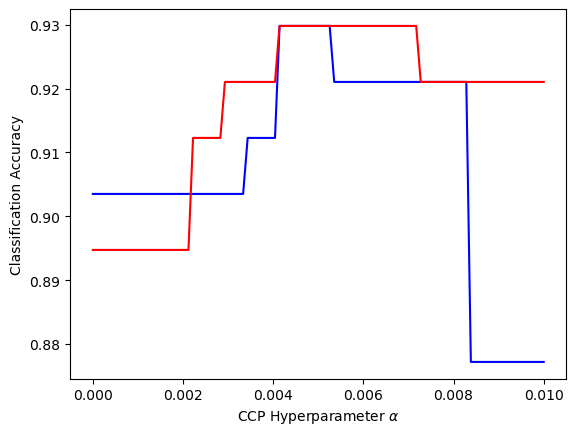

In [55]:
# Creating list for trimmed trees,
sk_clfs = []
sk_scores = []

# Looping over alpha values,
for ccp_alpha in ccp_alphas:

    # Fitting model,
    sk_clf = SKDecisionTreeClassifier(ccp_alpha=ccp_alpha, random_state=0)
    sk_clf.fit(X_train, y_train)
    sk_clfs.append(sk_clf)

    # Scoring each tree,
    sk_score = sk_clf.score(X_test, y_test)
    sk_scores.append(sk_score)


# Plotting,
plt.plot(ccp_alphas, scores, color="blue")
plt.plot(ccp_alphas, sk_scores, color="red")
plt.xlabel(r"CCP Hyperparameter $\alpha$")
plt.ylabel(r"Classification Accuracy")
plt.show()

### References

https://www.youtube.com/watch?v=VSoHJGx2Zpw

https://medium.com/@hsharsh777/cost-complexity-pruning-in-decision-trees-6ae934a5096e